#  Summary of CDS Return Replication

In [9]:
# Imports and path setup
import sys
from pathlib import Path

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Plotting style
sns.set()

# Add project root to path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

# Load project modules
from cds_returns import pull_fed_yield_curve, pull_fred, pull_markit_cds
from he_kelly_manela import pull_he_kelly_manela

# Load project settings
from settings import config

DATA_DIR = Path(config("DATA_DIR")) / "wrds_markit"
HE_DATA_DIR = Path(config("DATA_DIR")) / "he_kelly_manela"


In [2]:
# Change default pandas display options
pd.options.display.max_columns = 25
pd.options.display.max_rows = 500
pd.options.display.max_colwidth = 100
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# Change default figure size
plt.rcParams["figure.figsize"] = 6, 5

## 1. Introduction

This notebook replicates monthly CDS portfolio returns as constructed in He, Kelly, and Manela (2017) and Palhares (2013)'s paper *"Cash-Flow Maturity and Risk Premia in CDS Markets."*

> "For CDS, we construct 20 portfolios sorted by spreads using individual name 5-year contracts... Our definition of CDS returns follows Palhares (2013)."

While He, Kelly, and Manela (2017) construct CDS portfolios using data up to 2012, in this notebook we extend the sample period through 2024 for demonstration purposes.  



### Target Replication: Quarterly CDS Return Structure

The CDS return series consists of 20 portfolios, formed by sorting 5-year single-name CDS contracts into 4 quintiles based on credit spreads. Each month, returns are computed for portfolios within each quintile, producing 20 total portfolios.


In [3]:
he_kelly = pull_he_kelly_manela.load_he_kelly_manela_all(data_dir=HE_DATA_DIR)

In [4]:
col_lst = ["yyyymm"]
for i in range(1, 10):
    col_lst.append(f"CDS_0{i}")
for i in range(10, 21):
    col_lst.append(f"CDS_{i}")

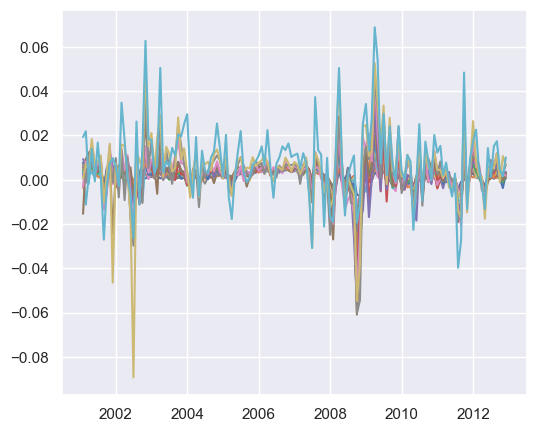

In [27]:
he_kelly_df = he_kelly[col_lst].dropna(axis=0)
he_kelly_df["Month"] = pd.to_datetime(he_kelly_df["yyyymm"].astype(int).astype(str), format="%Y%m")
he_kelly_df = he_kelly_df.drop(columns="yyyymm")
he_kelly_df = he_kelly_df.set_index("Month")
plt.plot(he_kelly_df);

## 2. Data Retrieval

We retrieve the datasets required to replicate the quarterly CDS returns. Retrieval scripts are modularized by source.

### 2.1 CDS Data from Markit

Following He et al. and Palhares, we use Markit as the source for CDS-related information. Specifically, we filter data by the following conditions:

- `currency = 'USD'`: USD-denominated CDS contracts only  
- `docclause LIKE 'XR%%'`: Only XR (no restructuring) contracts  
- `CompositeDepth5Y >= 3`: Minimum 3 dealer submissions for 5Y quotes  
- `tenor IN ('1Y', '3Y', '5Y', '7Y', '10Y')`: Focus on standard maturities


In [10]:
cds_df = pull_markit_cds.load_cds_data(data_dir=DATA_DIR)

In [11]:
cds_df.columns

Index(['date', 'ticker', 'redcode', 'parspread', 'convspreard', 'tenor',
       'country', 'creditdv01', 'riskypv01', 'irdv01', 'rec01', 'dp', 'jtd',
       'dtz', 'year'],
      dtype='object')

> **Columns in `markit_cds.parquet`**
> 
> 
> 
> - `date`: The date on which the CDS curve was calculated.
> 
> - `ticker`: Markit ticker symbol representing the reference entity.
> 
> - `reddode`: Unique Markit RED (Reference Entity Database) code.
> 
> - `parspread`: CDS par spread (in basis points); the fair premium for credit protection.
> 
> - `convspreard`: Conversion spread used to translate CDS prices into spreads.
> 
> - `tenor`: Maturity of the CDS contract (e.g., 1Y, 3Y, 5Y, 7Y, 10Y).
> 
> - `country`: Country of the reference entity.
> 
> - `creditdv01`: Change in CDS value from a 1 basis point change in credit spread.
> 
> - `riskypv01`: Present value of the risky annuity (expected PV of CDS payments).
> 
> - `irdv01`: Change in mark-to-market from a 1 bp shift in interest rates.
> 
> - `rec01`: Change in value from a 1% change in the assumed recovery rate.
> 
> - `dp`: Implied default probability of the reference entity.
> 
> - `jtd`: Jump-to-default — change in value assuming immediate credit event.
> 
> - `dtz`: Jump-to-zero — change in value assuming default and 0% recovery.
> 
> - `year`: The year the data was pulled from (based on source table like `CDS2019`).

We have also generated two additional CDS tables, which are not used directly in our calculations but are included in the `pull_markit_cds.py` script for reference:

1. `markit_red_crsp_link.parquet`:
A mapping table that links Markit RED codes to CRSP Permnos using CUSIP and Ticker, supplemented by a fuzzy-matched name similarity score (nameRatio) and a linking flag (flg), indicating the method used (CUSIP or Ticker).

2. `markit_cds_subsetted_to_crsp.parquet`:
A filtered subset of markit_cds.parquet that includes only records with RED codes successfully matched to CRSP Permnos (where nameRatio >= 50). This table is intended for use when merging CDS data with CRSP equity or financial datasets.

### 2.2 Federal Reserve Zero-Coupon Yields
In this step, we download and process the [U.S. Treasury zero-coupon yield curve data]((https://www.federalreserve.gov/econres/feds/the-us-treasury-yield-curve-1961-to-the-present.htm)) published by the Federal Reserve Board. This dataset is based on the Gürkaynak, Sack, and Wright (2007) methodology, which fits a smooth yield curve to observed Treasury yields.   
We retrieve zero-coupon yield data directly from the Federal Reserve, labeled SVENY01 to SVENY30, representing 1-year to 30-year maturities.


In [12]:
fed_df = pull_fed_yield_curve.load_fed_yield_curve(data_dir=DATA_DIR)

In [13]:
fed_df.columns

Index(['SVENY01', 'SVENY02', 'SVENY03', 'SVENY04', 'SVENY05', 'SVENY06',
       'SVENY07', 'SVENY08', 'SVENY09', 'SVENY10', 'SVENY11', 'SVENY12',
       'SVENY13', 'SVENY14', 'SVENY15', 'SVENY16', 'SVENY17', 'SVENY18',
       'SVENY19', 'SVENY20', 'SVENY21', 'SVENY22', 'SVENY23', 'SVENY24',
       'SVENY25', 'SVENY26', 'SVENY27', 'SVENY28', 'SVENY29', 'SVENY30'],
      dtype='object')

### 2.3 Treasury Yield Data

To calculate risk-free rates at shorter maturities, we also retrieve 3-month and 6-month Treasury yields (DGS3MO and DGS6MO) from FRED.

In [14]:
swap_rates_df = pull_fred.load_fred(data_dir=DATA_DIR)

In [15]:
swap_rates_df.head(5)

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3
DATE,,,,,,
2001-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-02,NaN,5.870,5.580,5.110,4.870,4.820
2001-01-03,NaN,5.690,5.440,5.040,4.920,4.920
2001-01-04,NaN,5.370,5.200,4.820,4.770,4.780
2001-01-05,NaN,5.120,4.980,4.600,4.560,4.570


## 3. Replication

We follow the return formula used in *He-Kelly-Manela (2017)*, referencing Palhares:

$$
\text{CDS}^{Ret}_t = \frac{\text{CDS}_{t-1}}{250} + \Delta \text{CDS}_t \cdot \text{RD}_{t-1}
$$

Where:

- $\frac{\text{CDS}_{t-1}}{250}$: **Carry return**, daily accrual from previous day’s spread (annualized over 250 days)  
- $\Delta \text{CDS}_t$: Daily change in spread  
- $\text{RD}_{t-1}$: **Risky duration**, proxy for PV of future spread payments

$$
\text{RD}_t = \frac{1}{4} \sum_{j=1}^{4M} e^{-j\lambda/4} \cdot e^{-jr_t^{(j/4)}/4}
$$

Where:

- $M$: CDS maturity (e.g., 5)  
- $r_t^{(j/4)}$: Quarterly risk-free rate  
- $\lambda$: Default intensity, computed as:

$$
\lambda = 4 \cdot \log \left(1 + \frac{\text{CDS}}{4L} \right), \quad L = 0.6
$$


### 3.1. Risk-Free Rate Calculation

We calculate the quarterly risk-free rates $r_t^{(j/4)}$ via interpolation, since the raw data is only available annually (plus 0.25Y and 0.5Y points). Cubic interpolation fills in missing quarterly maturities.

Even though returns are monthly, we retain quarterly rates under the assumption that CDS spreads are paid quarterly.

### 3.2. Monthly Return Computation

We compute monthly CDS returns by applying the above formula for each individual name and maturity. Spread data is first aligned and cleaned at the monthly frequency.

### 3.3. Portfolio Construction

We focus on U.S.-based 5Y CDS contracts and process spreads monthly. For each firm in each month, we keep only the **first observed 5Y par spread**, ensuring consistency in time series construction.

To sort firms into credit quality groups, we compute quintiles based on the cross-sectional distribution of 5Y spreads for each month. These breakpoints define five credit buckets (quantiles 1–5), from safest to riskiest.

We then assign each firm a quantile label based on their spread ranking. This quantile label is merged back into the full dataset, including other tenors (3Y, 7Y, 10Y), allowing us to analyze spread dynamics across maturities while controlling for credit quality.

Finally, we compute the **average par spread** for each combination of:

* Tenor ∈ {3Y, 5Y, 7Y, 10Y}
* Credit Quantile ∈ {1, 2, 3, 4, 5}

This results in 20 tenor–quantile portfolios, each with a monthly spread time series.



In [19]:
final_result = pd.read_parquet(DATA_DIR / "markit_cds_returns.parquet")
final_result = final_result.set_index("Month")
final_result.head(5)

,3Y_Q1,3Y_Q2,3Y_Q3,3Y_Q4,3Y_Q5,5Y_Q1,5Y_Q2,5Y_Q3,5Y_Q4,5Y_Q5,7Y_Q1,7Y_Q2,7Y_Q3,7Y_Q4,7Y_Q5,10Y_Q1,10Y_Q2,10Y_Q3,10Y_Q4,10Y_Q5
Month,,,,,,,,,,,,,,,,,,,,
2001-01-01,0.001,-0.001,-0.001,-0.000,0.010,0.000,0.001,0.001,0.005,-0.003,0.002,0.004,0.001,0.003,0.011,0.000,0.000,0.000,0.003,0.002
2001-02-01,-0.010,0.002,-0.000,0.000,0.003,-0.000,0.001,0.000,-0.001,0.003,-0.000,-0.001,0.001,-0.003,-0.023,0.001,0.002,0.002,0.001,0.002
2001-03-01,0.000,0.000,-0.005,0.001,-0.040,0.000,-0.001,0.000,0.000,0.021,0.000,-0.001,0.001,0.004,0.002,0.000,0.001,0.001,0.002,0.012
2001-04-01,0.000,0.001,0.001,-0.010,-0.006,0.001,0.000,-0.000,0.002,0.004,0.000,0.001,0.001,0.000,0.007,0.001,-0.001,0.003,0.001,0.008
2001-05-01,0.000,0.001,-0.001,0.000,-0.004,-0.000,0.000,0.002,-0.006,-0.015,0.002,0.000,-0.001,0.002,0.016,0.000,-0.001,-0.001,0.005,-0.020


## 4. Comparison

In [36]:
he_kelly_df.tail(5)

,CDS_01,CDS_02,CDS_03,CDS_04,CDS_05,CDS_06,CDS_07,CDS_08,CDS_09,CDS_10,CDS_11,CDS_12,CDS_13,CDS_14,CDS_15,CDS_16,CDS_17,CDS_18,CDS_19,CDS_20
Month,,,,,,,,,,,,,,,,,,,,
2012-08-01,0.001,0.001,0.001,0.001,0.002,0.002,0.002,0.002,0.002,0.003,0.003,0.002,0.004,0.003,0.004,0.006,0.008,0.006,0.005,0.015
2012-09-01,0.001,0.001,0.002,0.002,0.003,0.002,0.003,0.003,0.004,0.004,0.005,0.006,0.006,0.009,0.007,0.008,0.009,0.012,0.012,0.017
2012-10-01,0.001,0.001,0.001,0.002,0.002,0.002,0.001,0.001,0.002,0.001,0.001,0.003,0.004,0.004,0.001,0.004,0.003,0.003,-0.001,0.004
2012-11-01,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,-0.002,-0.002,0.001,-0.004,-0.001,-0.001,0.001,0.002,-0.000,0.003,0.003,0.011,0.002
2012-12-01,0.001,0.001,0.001,0.001,0.002,0.002,0.003,0.003,0.001,0.003,0.003,0.003,0.003,0.003,0.004,0.003,0.002,0.007,0.007,0.010


In [46]:
replication_df = final_result["2001-02-01":"2012-12-01"]

In [47]:
replication_df.head(5)

,3Y_Q1,3Y_Q2,3Y_Q3,3Y_Q4,3Y_Q5,5Y_Q1,5Y_Q2,5Y_Q3,5Y_Q4,5Y_Q5,7Y_Q1,7Y_Q2,7Y_Q3,7Y_Q4,7Y_Q5,10Y_Q1,10Y_Q2,10Y_Q3,10Y_Q4,10Y_Q5
Month,,,,,,,,,,,,,,,,,,,,
2001-02-01,-0.010,0.002,-0.000,0.000,0.003,-0.000,0.001,0.000,-0.001,0.003,-0.000,-0.001,0.001,-0.003,-0.023,0.001,0.002,0.002,0.001,0.002
2001-03-01,0.000,0.000,-0.005,0.001,-0.040,0.000,-0.001,0.000,0.000,0.021,0.000,-0.001,0.001,0.004,0.002,0.000,0.001,0.001,0.002,0.012
2001-04-01,0.000,0.001,0.001,-0.010,-0.006,0.001,0.000,-0.000,0.002,0.004,0.000,0.001,0.001,0.000,0.007,0.001,-0.001,0.003,0.001,0.008
2001-05-01,0.000,0.001,-0.001,0.000,-0.004,-0.000,0.000,0.002,-0.006,-0.015,0.002,0.000,-0.001,0.002,0.016,0.000,-0.001,-0.001,0.005,-0.020
2001-06-01,0.000,0.000,-0.001,-0.001,0.004,-0.000,0.001,-0.000,0.002,0.002,0.000,0.002,0.002,-0.000,0.003,0.000,0.001,-0.003,0.001,0.010


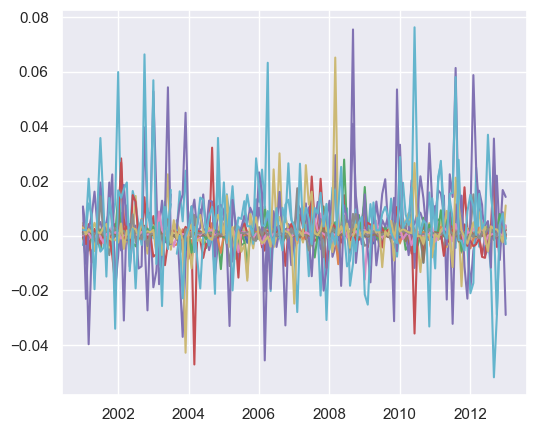

In [29]:
plt.plot(replication_df);

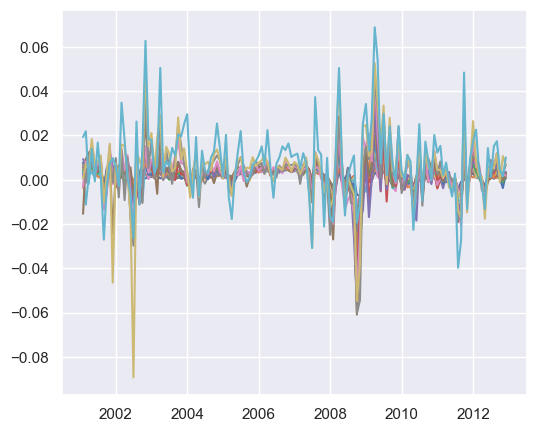

In [28]:
plt.plot(he_kelly_df);

In [48]:
nan_rows_rep = replication_df[replication_df.isna().any(axis=1)]
nan_rows_rep
#TODO: why?

,3Y_Q1,3Y_Q2,3Y_Q3,3Y_Q4,3Y_Q5,5Y_Q1,5Y_Q2,5Y_Q3,5Y_Q4,5Y_Q5,7Y_Q1,7Y_Q2,7Y_Q3,7Y_Q4,7Y_Q5,10Y_Q1,10Y_Q2,10Y_Q3,10Y_Q4,10Y_Q5
Month,,,,,,,,,,,,,,,,,,,,
2003-08-01,0.000,-0.003,NaN,0.002,NaN,0.000,-0.004,NaN,0.002,NaN,0.000,NaN,NaN,0.002,NaN,0.000,NaN,NaN,0.006,NaN


In [49]:
replication_df = replication_df.ffill()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

X = replication_df.T
Y = he_kelly_df.T

similarity_matrix = pd.DataFrame(
    cosine_similarity(X, Y),
    index=X.index,
    columns=Y.index
)

similarity_matrix.round(2)


,CDS_01,CDS_02,CDS_03,CDS_04,CDS_05,CDS_06,CDS_07,CDS_08,CDS_09,CDS_10,CDS_11,CDS_12,CDS_13,CDS_14,CDS_15,CDS_16,CDS_17,CDS_18,CDS_19,CDS_20
3Y_Q1,-0.450,-0.500,-0.500,-0.540,-0.570,-0.570,-0.520,-0.570,-0.570,-0.590,-0.620,-0.500,-0.630,-0.620,-0.580,-0.500,-0.530,-0.560,-0.460,-0.430
3Y_Q2,-0.000,0.030,0.060,0.050,0.040,0.050,0.020,-0.000,-0.020,-0.030,-0.030,-0.060,0.010,-0.020,-0.030,-0.020,-0.030,0.010,0.000,-0.040
3Y_Q3,-0.020,-0.050,0.020,0.000,-0.010,-0.040,-0.020,-0.020,-0.070,-0.050,-0.050,-0.030,-0.050,-0.060,-0.080,-0.050,-0.060,-0.080,0.020,-0.070
3Y_Q4,0.050,0.070,0.060,0.040,0.040,0.070,0.060,0.070,0.070,0.010,0.040,0.050,0.010,0.030,0.040,0.030,-0.020,-0.030,-0.020,0.060
3Y_Q5,0.030,0.070,0.030,0.050,-0.010,0.050,-0.000,-0.010,0.000,0.020,-0.020,-0.090,0.020,-0.030,-0.050,0.040,-0.050,-0.030,0.020,0.020
5Y_Q1,0.120,0.130,0.130,0.090,0.100,0.110,0.050,0.070,0.080,0.080,0.070,0.080,0.050,0.010,-0.010,0.050,0.080,0.070,0.160,0.120
5Y_Q2,0.050,0.100,-0.000,-0.000,-0.060,-0.050,-0.040,-0.090,-0.060,0.090,-0.050,-0.080,-0.070,-0.110,-0.050,-0.050,-0.090,-0.050,-0.050,-0.100
5Y_Q3,-0.010,-0.000,0.080,0.110,0.050,0.080,0.050,0.040,0.050,0.040,0.020,0.030,-0.010,0.040,-0.020,0.030,-0.010,0.010,0.040,0.110
5Y_Q4,0.110,0.090,0.090,0.090,0.080,0.060,0.070,0.060,0.080,0.040,0.030,0.010,0.000,0.010,-0.030,0.020,-0.020,-0.030,-0.090,-0.010
5Y_Q5,0.030,0.040,0.090,0.010,0.040,0.030,-0.040,0.010,0.040,-0.090,0.010,0.000,-0.030,-0.040,-0.060,-0.010,-0.040,-0.020,-0.010,0.080


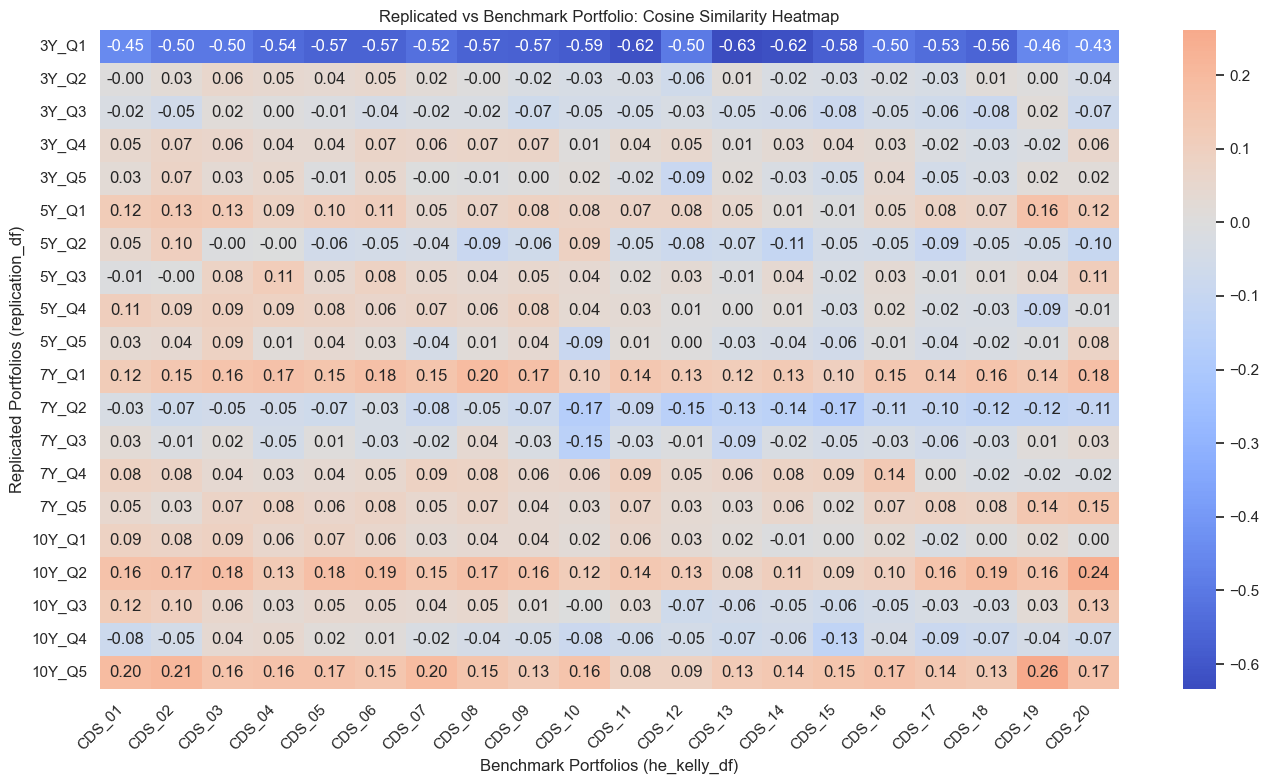

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)

plt.title("Replicated vs Benchmark Portfolio: Cosine Similarity Heatmap")
plt.xlabel("Benchmark Portfolios (he_kelly_df)")
plt.ylabel("Replicated Portfolios (replication_df)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:

correlation_matrix = pd.DataFrame(index=X.index, columns=Y.index)

for rep_col in X.index:
    for bench_col in Y.index:
        correlation_matrix.loc[rep_col, bench_col] = X.loc[rep_col].corr(Y.loc[bench_col])

correlation_matrix = correlation_matrix.astype(float)

correlation_matrix.round(2)


,CDS_01,CDS_02,CDS_03,CDS_04,CDS_05,CDS_06,CDS_07,CDS_08,CDS_09,CDS_10,CDS_11,CDS_12,CDS_13,CDS_14,CDS_15,CDS_16,CDS_17,CDS_18,CDS_19,CDS_20
3Y_Q1,-0.560,-0.640,-0.630,-0.640,-0.700,-0.670,-0.630,-0.680,-0.660,-0.650,-0.690,-0.550,-0.690,-0.670,-0.610,-0.550,-0.590,-0.610,-0.520,-0.540
3Y_Q2,-0.080,-0.050,-0.020,-0.010,-0.030,-0.010,-0.040,-0.070,-0.080,-0.080,-0.080,-0.110,-0.020,-0.060,-0.060,-0.060,-0.080,-0.030,-0.040,-0.120
3Y_Q3,-0.110,-0.160,-0.080,-0.080,-0.100,-0.120,-0.100,-0.110,-0.140,-0.110,-0.110,-0.080,-0.100,-0.110,-0.120,-0.100,-0.120,-0.140,-0.040,-0.170
3Y_Q4,-0.000,0.020,0.010,-0.000,-0.020,0.020,0.010,0.020,0.030,-0.030,-0.000,0.020,-0.020,0.000,0.020,0.000,-0.050,-0.060,-0.050,0.000
3Y_Q5,-0.070,-0.020,-0.070,-0.030,-0.110,-0.030,-0.090,-0.100,-0.070,-0.040,-0.080,-0.150,-0.030,-0.080,-0.090,-0.010,-0.110,-0.080,-0.040,-0.080
5Y_Q1,0.010,0.020,0.010,-0.010,-0.020,0.010,-0.060,-0.040,-0.010,0.000,-0.010,0.010,-0.010,-0.050,-0.060,-0.020,0.010,0.010,0.100,0.010
5Y_Q2,-0.050,0.000,-0.120,-0.100,-0.170,-0.150,-0.140,-0.200,-0.150,0.030,-0.130,-0.140,-0.120,-0.170,-0.090,-0.110,-0.160,-0.110,-0.120,-0.220
5Y_Q3,-0.090,-0.090,0.000,0.060,-0.030,0.020,-0.020,-0.030,-0.010,-0.010,-0.040,-0.010,-0.050,0.000,-0.060,-0.010,-0.060,-0.030,-0.010,0.040
5Y_Q4,0.040,0.010,0.020,0.030,0.010,-0.000,0.000,-0.010,0.030,-0.010,-0.020,-0.040,-0.040,-0.030,-0.070,-0.020,-0.070,-0.070,-0.150,-0.090
5Y_Q5,-0.100,-0.100,-0.040,-0.100,-0.090,-0.090,-0.170,-0.110,-0.070,-0.180,-0.080,-0.070,-0.110,-0.110,-0.120,-0.080,-0.120,-0.100,-0.100,-0.050


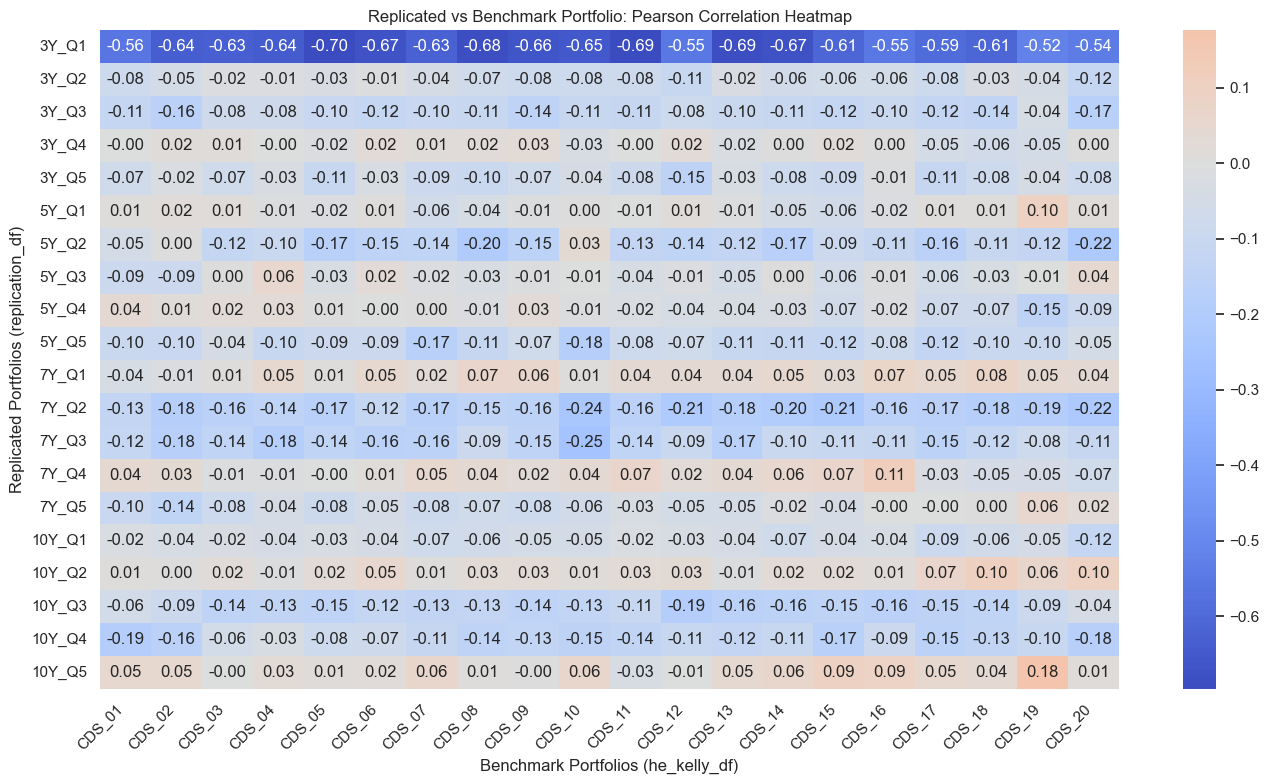

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)

plt.title("Replicated vs Benchmark Portfolio: Pearson Correlation Heatmap")
plt.xlabel("Benchmark Portfolios (he_kelly_df)")
plt.ylabel("Replicated Portfolios (replication_df)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


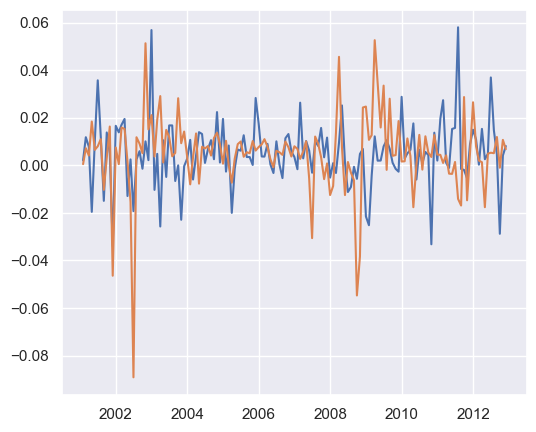

In [59]:
plt.plot(replication_df["10Y_Q5"]);
plt.plot(he_kelly_df["CDS_19"]);